# Analysis of fluorescent microplastic images, sizes identification

This notebook helps in analyzing images to detect and classify microplastics, according to size. We will process images to identify particles of different sizes and visualize the results.
*Fluorescent microplastic image-  as example


Step 1: Import Required Libraries

In [54]:
!pip install opencv-python
import cv2
import numpy as np
import colorsys
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.stats import f_oneway, ttest_ind
from scipy import stats

import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting

Step 2: Image Processing

Replace '**my_image_exact_name.jpeg**' with the path to your image file. This section will process the image, detect particles, and classify them based on size.

Remember!
If you use Google Colab, the image gets lost after you close it.

Ensure that your files are saved elsewhere. The runtime's files will be deleted when the runtime is terminated.

In [55]:
def read_image(image_path):
    """Reads an image from the specified path."""
    return cv2.imread(image_path)

def convert_to_hsv(image):
    """Converts an image from BGR to HSV color space."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def create_red_mask(hsv_image):
    """Creates a mask for detecting red color in the image."""
    # Define range for red color in HSV, the microplastic in the EXAMPLE image
    #is red fluorescent.


    # The specific HSV values lower_red1 = np.array([0, 120, 70])
    # and upper_red1 = np.array([10, 255, 255]) for detecting red color
    # are chosen based on the properties of the HSV color space
    # and practical experience in image processing.
    # In HSV, hue represents the type of color, saturation its vibrancy,
    # and value its brightness. Red colors are uniquely positioned at the edges
    # of the hue spectrum, around 0 and 180 degrees.
    # Thus, to capture all shades of red, two ranges are defined:
    # one close to 0 degrees and another close to 180 degrees.
    # The lower and upper values for saturation and brightness ensure that
    # the colors are sufficiently vibrant and visible.
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)

    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)

    return mask1 + mask2

Step 3: Processing the Image

In [56]:
def process_image(image_path):
    """Processes the image to detect and classify particles."""
    img = read_image(image_path)
    hsv = convert_to_hsv(img)
    mask = create_red_mask(hsv)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Parameters for particle classification (this is an example for a
    # microplastic with 5.0 micrometers SD of 0.23)
    min_size_micrometers = 4.77
    max_size_micrometers = 5.23
    # The pixel to size ratio MUST BE according to the METADATA seen in your
    # microscope image file,
    # Make sure to check it and insert bellow the pixel to size ratio of YOUR image.
    pixel_to_size_ratio = 0.1836

    # Initialize counters and lists
    particle_sizes = {'white': [], 'yellow': [], 'blue': []}
    counts = {'big': 0, 'micro': 0, 'minor': 0}

    image_with_circle = {'white': img.copy(), 'yellow': img.copy(), 'blue': img.copy()}

    for cnt in contours:
        # opencv minEnclosingCircle uses Welzl algorithm to do the minimum enclosing circle (MEC)
        # see Welzl, Emo. Smallest enclosing disks (balls and ellipsoids). Springer Berlin Heidelberg, 1991.
        # https://github.com/opencv/opencv/blob/master/modules/imgproc/src/shapedescr.cpp#L206
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        radius_micrometers = radius * pixel_to_size_ratio
        diameter_micrometers = radius_micrometers * 2

        center = (int(x), int(y))
        radius = int(radius)

        if min_size_micrometers <= diameter_micrometers <= max_size_micrometers:
            color = 'white'
            counts['micro'] += 1
            particle_sizes['white'].append(diameter_micrometers)
            circle_color = (255, 255, 255)  # White
        elif diameter_micrometers < min_size_micrometers:
            color = 'yellow'
            counts['minor'] += 1
            particle_sizes['yellow'].append(diameter_micrometers)
            circle_color = (0, 230, 255)  # Yellow
        else:
            color = 'blue'
            counts['big'] += 1
            particle_sizes['blue'].append(diameter_micrometers)
            circle_color = (255, 0, 0)  # Blue

        cv2.circle(image_with_circle[color], center, radius, circle_color, 20)

    return particle_sizes, counts, image_with_circle

def cv2_imshow(cv2image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB))

# Example of Use
<hr>

Bigger than 5.23 micrometers microplastics count: 147
5.0 micrometers microplastics count: 50
Minor than 4,73 micrometers microplastics count: 6831
Particles >=4.77µm and <=5.23µm Stats:
Mean Size: 4.97790268876648 µm, Standard Deviation: 0.13715808988778208 µm
Particles <4.77µm Stats:
Mean Size: 1.7807436883006373 µm, Standard Deviation: 0.7012415256042535 µm
Particles >5.23µm Stats:
Mean Size: 8.571408801316243 µm, Standard Deviation: 7.763226028830422 µm


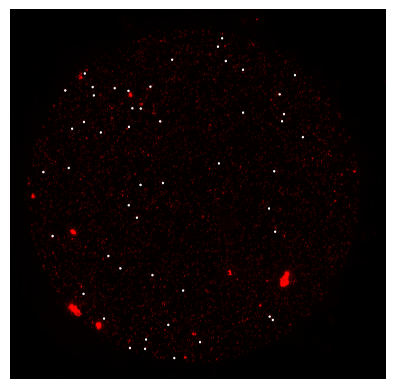

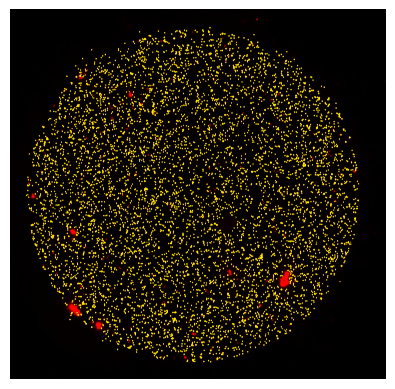

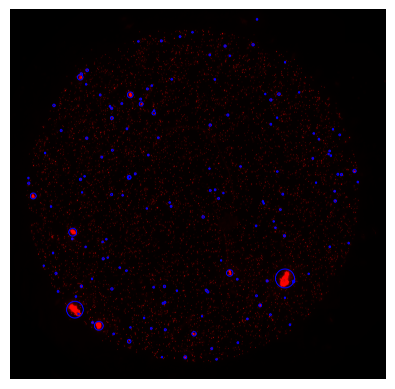

In [57]:
# Example
# Replace 'my_image_exact_name.jpg' with your actual image file name.
# This cell will process the image and show the results.

## Replace with your image path
image_path = 'my_image_exact_name.jpg'

particle_sizes, counts, image_with_circle = process_image(image_path)

## Print particle counts
print(f"Bigger than 5.23 micrometers microplastics count: {counts['big']}")
print(f"5.0 micrometers microplastics count: {counts['micro']}")
print(f"Minor than 4,73 micrometers microplastics count: {counts['minor']}")

## Calculate statistics for each size category
def calculate_statistics(sizes):
    """Calculate mean and standard deviation of particle sizes."""
    return {
        'mean': np.mean(sizes),
        'std': np.std(sizes)
    }

stats = {
    'white': calculate_statistics(particle_sizes['white']),
    'yellow': calculate_statistics(particle_sizes['yellow']),
    'blue': calculate_statistics(particle_sizes['blue'])
}

cv2_imshow(image_with_circle['white'])
cv2_imshow(image_with_circle['yellow'])
cv2_imshow(image_with_circle['blue'])

print("Particles >=4.77µm and <=5.23µm Stats:")
print(f"Mean Size: {stats['white']['mean']} µm, Standard Deviation: {stats['white']['std']} µm")
print("Particles <4.77µm Stats:")
print(f"Mean Size: {stats['yellow']['mean']} µm, Standard Deviation: {stats['yellow']['std']} µm")
print("Particles >5.23µm Stats:")
print(f"Mean Size: {stats['blue']['mean']} µm, Standard Deviation: {stats['blue']['std']} µm")